# Monte Carlo Nullpoint Approach - Code Description

This code only looks at the Residual Sum of Squares results

# Import Libraries

In [1]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import sklearn
from sklearn.cluster import KMeans
import colorsys
from datetime import date
import pickle

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [2]:
#Process Related Options

intEnds = True
randStart = False            #Enables the multistart option for curve_fit

# Initialize Parameters and Arrays

In [3]:
#Assumed echo time points
TE_series = np.linspace(8, 512, 64) #ms units
assert(TE_series[-1] == 512)
TE_diff = np.mean(np.diff(TE_series))
assert(TE_diff == 8)

#Parameters that dictate process related features
repetitions = 10     #number of noise realizations averaged

#Curve Fit Trials - how many times do we run curve_fit before we take a parameter fit solution
if randStart:
    randStart_trials = 10
else:
    randStart_trials = 1

######All Fixed parameters for code
#Parameters held constant
c1 = 0.4
c2 = 0.6 
T21 = 45
T22 = 100
T11 = 600
T12 = 1200

initParams = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

ub_biX = (1,1,T2_bound,T2_bound)
lb_biX = (-1,-1,0,0)

ub_moX = (1,T2_bound)
lb_moX = (-1,0)

#Information determing TI range
nullResolution = 0.5
nullRadius = 20  #20

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#SNR Array to Generate
SNR_array = np.array([750, 1000, 3000, 10000])

standard_array = np.arange(-nullRadius, nullRadius+0.01, nullResolution)
if intEnds:
    TI1_array = np.floor(TI1star) + standard_array
    TI2_array = np.floor(TI2star) + standard_array
else:
    TI1_array = TI1star + standard_array
    TI2_array = TI2star + standard_array

ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']
round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

# Define Functions

In [4]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def add_noise(data,SNR):
    #returns a noised vector of data using the SNR given
    sigma = (c1+c2)/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# SNR Level Results

In [ ]:
TI_max_sig = 0

##### Determine Offset of RSS Due to SNR

In [9]:
SNR_RSS_biX_array_TI1 = np.zeros((TI1_array.shape[0], np.size(SNR_array)))
SNR_RSS_biX_array_TI2 = np.zeros((TI2_array.shape[0], np.size(SNR_array)))

SNR_RSS_moX_array_TI1 = np.zeros((TI1_array.shape[0], np.size(SNR_array)))
SNR_RSS_moX_array_TI2 = np.zeros((TI2_array.shape[0], np.size(SNR_array)))

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theo_moX_TI1 = np.zeros(TI1_array.shape)

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theo_moX_TI2 = np.zeros(TI2_array.shape)

for k in trange(np.size(TI1_array)):

    #process TI1 array and TI2 array simultaneously
    TI1 = TI1_array[k]
    RSS_theo_moX_TI1[k] = R0_coeff_TI1*(TI1 - TI1star)**2

    TI2 = TI2_array[k]
    RSS_theo_moX_TI2[k] = R0_coeff_TI2*(TI2 - TI2star)**2
    
    true_d1_TI1 = d_value(TI1, c1, T11)
    true_d2_TI1 = d_value(TI1, c2, T12)

    realParams_4p_TI1 = np.array([true_d1_TI1, true_d2_TI1, T21, T22])

    true_d1_TI2 = d_value(TI2, c1, T11)
    true_d2_TI2 = d_value(TI2, c2, T12)

    realParams_4p_TI2 = np.array([true_d1_TI2, true_d2_TI2, T21, T22])

    trueDat_TI1 = S_biX_6p(TE_series, TI1, T11, T12, c1, c2, T21, T22)
    trueDat_TI2 = S_biX_6p(TE_series, TI2, T11, T12, c1, c2, T21, T22)

    for iSNR in range(np.size(SNR_array)):
        
        repMat_biX_TI1 = []
        repMat_biX_TI2 = []

        repMat_moX_TI1 = []
        repMat_moX_TI2 = []

        for rep in range(repetitions):

            noiseDat_T1 = add_noise(trueDat_TI1, SNR_array[iSNR])
            noiseDat_T2 = add_noise(trueDat_TI2, SNR_array[iSNR])


            ########### Null Point 1 - Biexponential ###########
            init_p = realParams_4p_TI1
                
            popt_biX_TI1, _ = curve_fit(S_biX_4p, TE_series, noiseDat_T1, p0 = init_p, bounds = [lb_biX,ub_biX], method = 'trf', maxfev = 1500)
            popt_biX_TI1 = check_param_order(popt_biX_TI1)
            est_Sig_biX_TI1 = S_biX_4p(TE_series, *popt_biX_TI1)

            repMat_biX_TI1.append( np.sum((est_Sig_biX_TI1 - noiseDat_T1)**2))

            ########### Null Point 1 - Monoexponential ###########
            init_p = [np.median(realParams_4p_TI1[0:2]),np.median(realParams_4p_TI1[2:])]
                
            popt_moX_TI1, _ = curve_fit(S_moX_2p, TE_series, noiseDat_T1, p0 = init_p, bounds = [lb_moX,ub_moX], method = 'trf', maxfev = 1500)
            popt_moX_TI1 = check_param_order(popt_moX_TI1)
            est_Sig_moX_TI1 = S_moX_2p(TE_series, *popt_moX_TI1)

            repMat_moX_TI1.append( np.sum((est_Sig_moX_TI1 - noiseDat_T1)**2))

            ########### Null Point 2 - Biexponential ###########
            init_p = realParams_4p_TI2

            popt_2E_TI2, _ = curve_fit(S_biX_4p, TE_series, noiseDat_T2, p0 = init_p, bounds = [lb_biX,ub_biX], method = 'trf', maxfev = 1500)
            popt_2E_TI2 = check_param_order(popt_2E_TI2)
            est_Sig_2E_TI2 = S_biX_4p(TE_series, *popt_2E_TI2)

            repMat_biX_TI2.append( np.sum((est_Sig_2E_TI2 - noiseDat_T2)**2))

            ########### Null Point 2 - Monoexponential ###########
            init_p = [np.median(realParams_4p_TI2[0:2]),np.median(realParams_4p_TI2[2:])]
                
            popt_moX_TI2, _ = curve_fit(S_moX_2p, TE_series, noiseDat_T2, p0 = init_p, bounds = [lb_moX,ub_moX], method = 'trf', maxfev = 1500)
            popt_moX_TI2 = check_param_order(popt_moX_TI2)
            est_Sig_moX_TI2 = S_moX_2p(TE_series, *popt_moX_TI2)

            repMat_moX_TI2.append( np.sum((est_Sig_moX_TI2 - noiseDat_T2)**2))

        SNR_RSS_biX_array_TI1[k, iSNR] = np.mean(repMat_biX_TI1)
        SNR_RSS_biX_array_TI2[k, iSNR] = np.mean(repMat_biX_TI2)

        SNR_RSS_moX_array_TI1[k, iSNR] = np.mean(repMat_moX_TI1)
        SNR_RSS_moX_array_TI2[k, iSNR] = np.mean(repMat_moX_TI2)

100%|██████████| 81/81 [02:06<00:00,  1.56s/it]


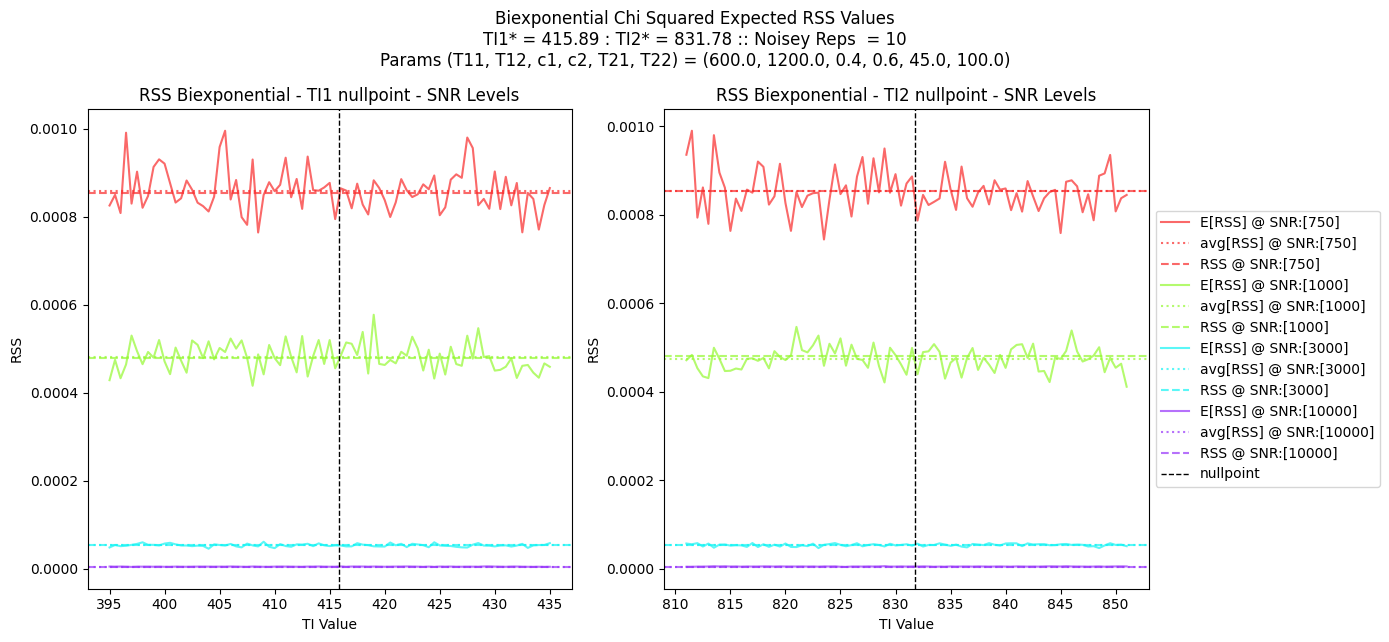

In [14]:
RSS_levels_colors = _get_colors(np.size(SNR_array))
RSS_levels_biX = (np.size(TE_series)-4)*(1/SNR_array)**2

details_RSS = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) + " :: Noisey Reps  = " + str(repetitions) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')

fig, ax = plt.subplots(1,2, figsize=(14,6.5), tight_layout=True)
fig.suptitle('Biexponential Chi Squared Expected RSS Values' + details_RSS)

for iPlot in range(np.size(SNR_array)):
    ax[0].plot(TI1_array, SNR_RSS_biX_array_TI1[:,iPlot]*TE_diff, label = f'RSS @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    ax[0].axhline(y = np.mean(SNR_RSS_biX_array_TI1[:,iPlot]*TE_diff), label = f'avg[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = ':')
    ax[0].axhline(y = RSS_levels_biX[iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('RSS Biexponential - TI1 nullpoint - SNR Levels')

for iPlot in range(np.size(SNR_array)):
    ax[1].plot(TI2_array, SNR_RSS_biX_array_TI2[:,iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    ax[1].axhline(y = np.mean(SNR_RSS_biX_array_TI2[:,iPlot]*TE_diff), label = f'avg[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = ':')
    ax[1].axhline(y = RSS_levels_biX[iPlot]*TE_diff, label = f'RSS @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS Biexponential - TI2 nullpoint - SNR Levels')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

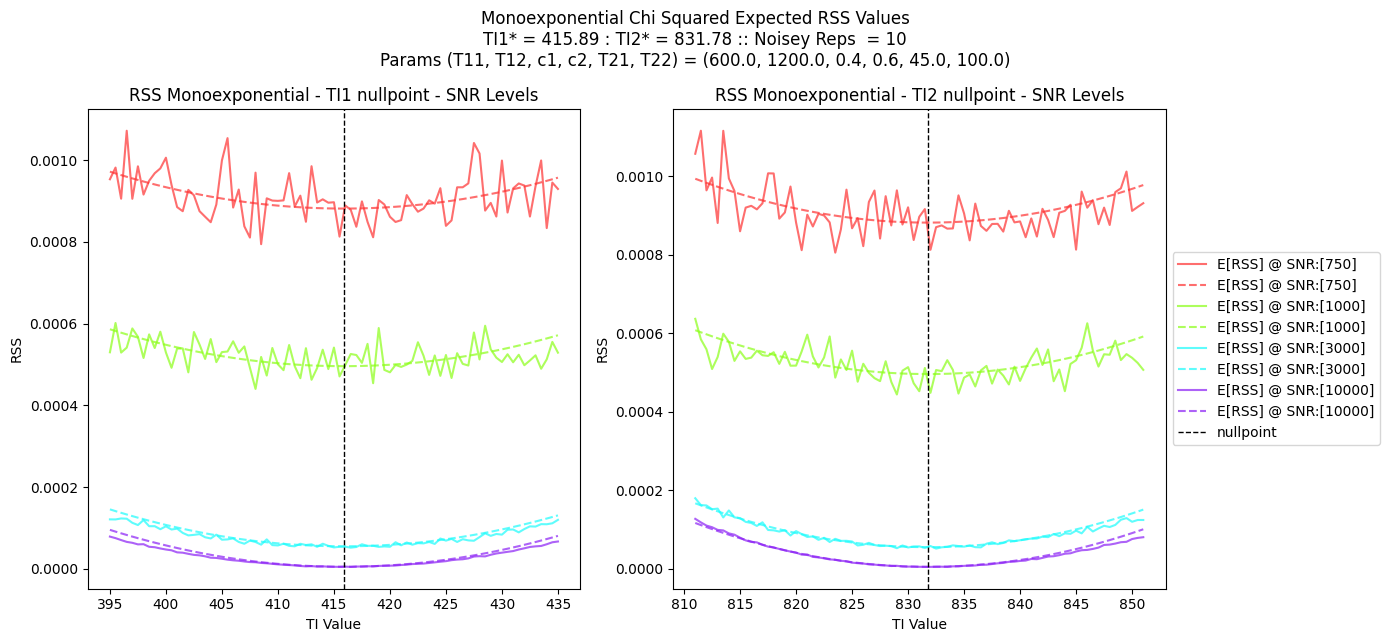

In [17]:
RSS_levels_colors = _get_colors(np.size(SNR_array))

RSS_levels_moX = (np.size(TE_series)-2)*(1/SNR_array)**2

details_RSS = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) + " :: Noisey Reps  = " + str(repetitions) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')

fig, ax = plt.subplots(1,2, figsize=(14,6.5), tight_layout=True)
fig.suptitle('Monoexponential Chi Squared Expected RSS Values' + details_RSS)

for iPlot in range(np.size(SNR_array)):
    ax[0].plot(TI1_array, SNR_RSS_moX_array_TI1[:,iPlot]*TE_diff, label = f'RSS @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    # ax[0].axhline(y = np.mean(SNR_RSS_biX_array_TI1[:,iPlot]*TE_diff), label = f'avg[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = ':')
    ax[0].plot(TI1_array, RSS_theo_moX_TI1 + RSS_levels_moX[iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('RSS Monoexponential - TI1 nullpoint - SNR Levels')

for iPlot in range(np.size(SNR_array)):
    ax[1].plot(TI2_array, SNR_RSS_moX_array_TI2[:,iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    # ax[1].axhline(y = np.mean(SNR_RSS_biX_array_TI2[:,iPlot]*TE_diff), label = f'avg[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = ':')
    ax[1].plot(TI2_array, RSS_theo_moX_TI2 + RSS_levels_moX[iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS Monoexponential - TI2 nullpoint - SNR Levels')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

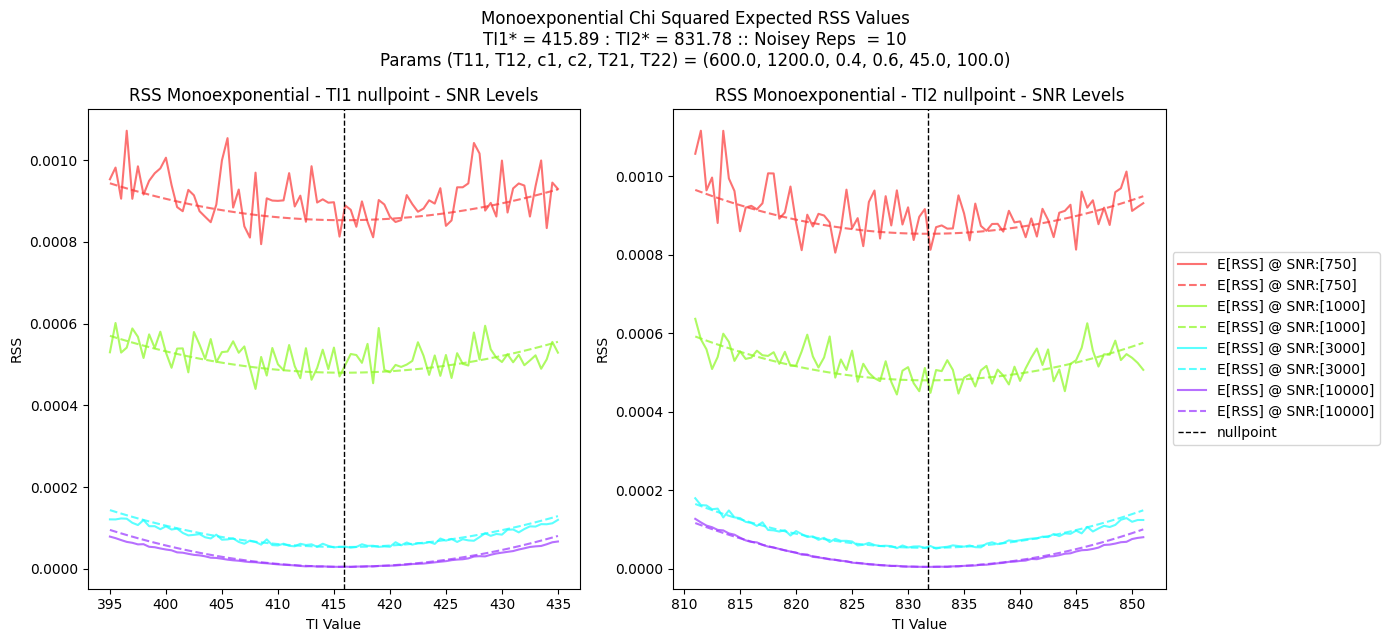

In [16]:


details_RSS = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) + " :: Noisey Reps  = " + str(repetitions) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')

fig, ax = plt.subplots(1,2, figsize=(14,6.5), tight_layout=True)
fig.suptitle('Monoexponential Chi Squared Expected RSS Values' + details_RSS)

for iPlot in range(np.size(SNR_array)):
    ax[0].plot(TI1_array, SNR_RSS_moX_array_TI1[:,iPlot]*TE_diff, label = f'RSS @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    # ax[0].axhline(y = np.mean(SNR_RSS_biX_array_TI1[:,iPlot]*TE_diff), label = f'avg[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = ':')
    ax[0].plot(TI1_array, RSS_theo_moX_TI1 + RSS_levels[iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('RSS Monoexponential - TI1 nullpoint - SNR Levels')

for iPlot in range(np.size(SNR_array)):
    ax[1].plot(TI2_array, SNR_RSS_moX_array_TI2[:,iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    # ax[1].axhline(y = np.mean(SNR_RSS_biX_array_TI2[:,iPlot]*TE_diff), label = f'avg[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = ':')
    ax[1].plot(TI2_array, RSS_theo_moX_TI2 + RSS_levels[iPlot]*TE_diff, label = f'E[RSS] @ SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS Monoexponential - TI2 nullpoint - SNR Levels')

ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()